<a href="https://colab.research.google.com/github/Vicente836/Practica-Ihealth/blob/S7/segm_to_mesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -qq xvfb libgl1-mesa-glx
!pip install pyvista -qq
import pyvista
pyvista.set_jupyter_backend('static')
pyvista.global_theme.notebook = True
pyvista.start_xvfb()

Selecting previously unselected package libfontenc1:amd64.
(Reading database ... 123632 files and directories currently installed.)
Preparing to unpack .../0-libfontenc1_1%3a1.1.4-1build3_amd64.deb ...
Unpacking libfontenc1:amd64 (1:1.1.4-1build3) ...
Selecting previously unselected package libgl1-mesa-glx:amd64.
Preparing to unpack .../1-libgl1-mesa-glx_23.0.4-0ubuntu1~22.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
Selecting previously unselected package libxfont2:amd64.
Preparing to unpack .../2-libxfont2_1%3a2.0.5-1build1_amd64.deb ...
Unpacking libxfont2:amd64 (1:2.0.5-1build1) ...
Selecting previously unselected package libxkbfile1:amd64.
Preparing to unpack .../3-libxkbfile1_1%3a1.1.0-1build3_amd64.deb ...
Unpacking libxkbfile1:amd64 (1:1.1.0-1build3) ...
Selecting previously unselected package x11-xkb-utils.
Preparing to unpack .../4-x11-xkb-utils_7.7+5build4_amd64.deb ...
Unpacking x11-xkb-utils (7.7+5build4) ...
Selecting previously unselec

In [144]:
!pip install meshio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 4.7 MB/s eta 0:00:00


In [145]:
import nibabel as nib
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import meshio

In [151]:
nifti_file = '0771_EC_ED_segm.nii'
# Load the NIfTI file

def nifti_to_mesh(nifti_file, axis='4CH'):
  nifti_data = nib.load(nifti_file)
  affine = nifti_data.affine
  # Extract the image data as a NumPy array
  image_data = nifti_data.get_fdata()
  spacing = nifti_data.header.get_zooms()
  voxel_x = spacing[0]
  voxel_y = spacing[1]
  voxel_z =  spacing[2]
  N_x = image_data.shape[0]
  N_y = image_data.shape[1]
  num_slices = image_data.shape[2]
  LV_edges = []
  RV_edges = []
  EPI_edges = []
  slices = []


  # select a slice from the nifti file
  for i in range(num_slices):
    sl = image_data[:,:,i]

    # Create the plane
    plane = pv.Plane(
        center=(0, 0, voxel_z*i),       # Center of the plane
        direction=(0, 0, 1),    # Normal vector to the plane
        i_size=N_x*voxel_y,          # Size in the x direction
        j_size=N_y*voxel_y,          # Size in the y direction
        i_resolution=N_x,  # Subdivisions along the x-axis
        j_resolution=N_y)   # Subdivisions along the y-axis

    plane['values'] = sl.flatten()

    # Get voxel coordinates from the grid
    voxel_coords = np.c_[plane.points, np.ones(plane.n_points)]  # Add ones for affine transformation
    # Transform voxel coordinates to real-world coordinates
    real_world_coords = voxel_coords @ affine.T  # Matrix multiplication
    # Update the grid points with the transformed real-world coordinates
    #plane.points = real_world_coords[:, :3]

    # check if there ir points in each segment of this slice
    if axis=='4CH':
      edge = []
      RV = plane.threshold((1,1.1)).extract_feature_edges()
      EPI_extra = plane.threshold((1,3.1)).extract_feature_edges()
      LV = plane.threshold((3,3.1)).extract_feature_edges()
      EPI = pv.PolyData([])
      if len(EPI_extra.points)>0:
        EPI = EPI_extra.threshold((2,2.1))
      if len(RV.points) > 0:
        RV_edges.append(RV)
        edge.append(RV)
      if len(EPI.points) > 0:
        EPI_edges.append(EPI)
        edge.append(EPI)
      if len(LV.points) > 0:
        LV_edges.append(LV)
        edge.append(LV)
      #save all edges merged in this slice
      if len(edge)>0:
        slices.append(pv.merge(edge))


    if axis=='ELVI':
      edge=[]
      LV = plane.threshold((2,2.1)).extract_feature_edges()
      EPI_extra = plane.threshold((1,2.1)).extract_feature_edges()
      EPI = pv.PolyData([])
      if len(EPI_extra.points)>0:
        EPI = EPI_extra.threshold((1,1.1))
      if len(EPI.points) > 0:
        EPI_edges.append(EPI)
        edge.append(EPI)
      if len(LV.points) > 0:
        LV_edges.append(LV)
        edge.append(LV)
      #save all edges merged in this slice
      if len(edge)>0:
        slices.append(pv.merge(edge))

    if axis=='EC':
      edge = []
      RV = plane.threshold((1,1.1)).extract_feature_edges()
      LV = plane.threshold((3,3.1)).extract_feature_edges()
      EPI_extra  = plane.threshold((1,3.1)).extract_feature_edges()
      EPI=pv.PolyData([])
      if len(EPI_extra.points)>0:
        EPI = EPI_extra.threshold((2,2.1))
      # Check if the in this slice each segment have points
      #EPI=None
      if len(EPI.points) > 0:
        EPI_edges.append(EPI)
        edge.append(EPI)
      if len(RV.points) > 0:
        RV_edges.append(RV)
        edge.append(RV)
      if len(LV.points) > 0:
        LV_edges.append(LV)
        edge.append(LV)
      if len(edge)>0:
        slices.append(pv.merge(edge))

  LV_final = []
  RV_final = []
  EPI_final = []
  if LV_edges:
    LV_final = pv.merge(LV_edges)
  if RV_edges:
    RV_final = pv.merge(RV_edges)
  if EPI_edges:
    EPI_final = pv.merge(EPI_edges)
  data_segm = [LV_final, RV_final, EPI_final]
  return data_segm, slices


In [152]:
data_segm_4CH, slices_4CH = nifti_to_mesh('0771_4CH_ED_segm.nii', axis='4CH')
LV_4CH, RV_4CH, EPI_4CH = data_segm_4CH
data_segm_EC, slices_EC = nifti_to_mesh('0771_EC_ED_segm.nii', axis='EC')
LV_EC, RV_EC, EPI_EC = data_segm_EC
data_segm_ELVI, slices_ELVI = nifti_to_mesh('0771_ELVI_ED_segm.nii', axis='ELVI')
LV_ELVI, RV_ELVI, EPI_ELVI = data_segm_ELVI

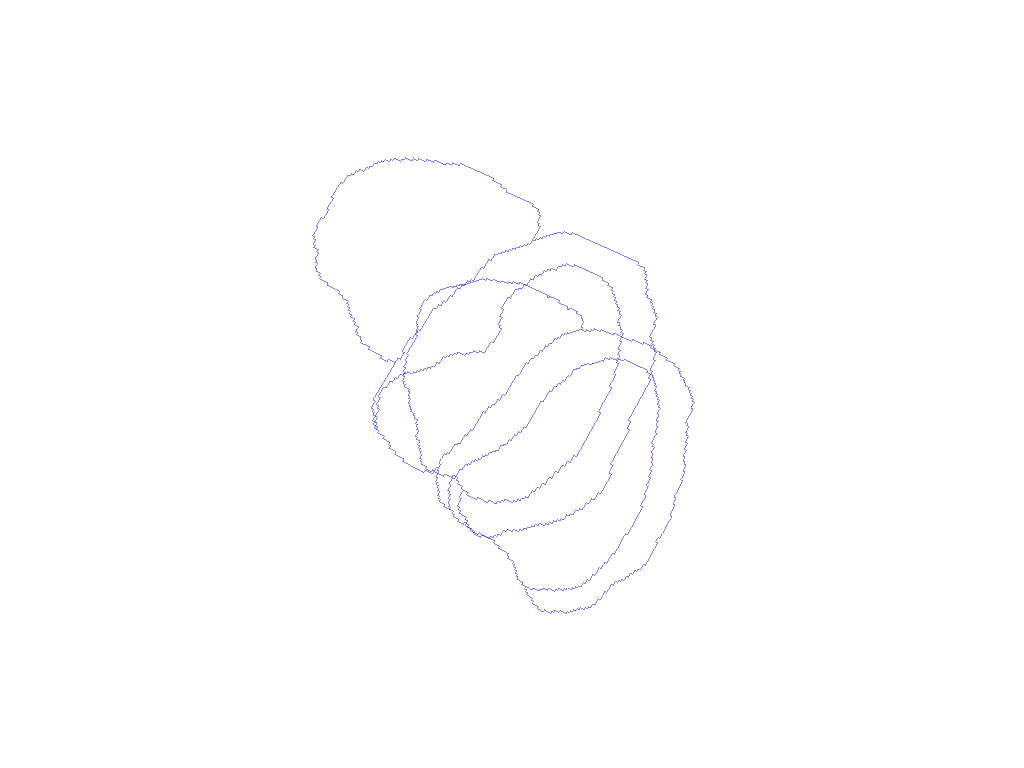

In [103]:
model = pv.merge(slices_4CH)
p = pv.Plotter()
#p.add_mesh(LV_4CH, color = 'red', opacity=0.5)
#p.add_mesh(RV_4CH, color = 'blue', opacity = 0.5)
#p.add_mesh(EPI_4CH, color = 'green', opacity=0.5)
#p.add_mesh(slices_4CH[0], color = 'red', opacity=0.5)
#p.add_mesh(slices_4CH[1], color = 'green', opacity=0.5)
p.add_mesh(model, color = 'blue', opacity=0.5)
p.show()

In [135]:
nifti_file = '0771_EC_ED_segm.nii'
nifti_data = nib.load(nifti_file)
affine = nifti_data.affine
# Extract the image data as a NumPy array
image_data = nifti_data.get_fdata()
spacing = nifti_data.header.get_zooms()
voxel_x = spacing[0]
voxel_y = spacing[1]
voxel_z =  spacing[2]
N_x = image_data.shape[0]
N_y = image_data.shape[1]
num_slices = image_data.shape[2]
LV_edges = []
RV_edges = []
EPI_edges = []
slices = []

i=7
sl = image_data[:,:,i]
# Create the plane
plane = pv.Plane(
    center=(0, 0, voxel_z*i),       # Center of the plane
    direction=(0, 0, 1),    # Normal vector to the plane
    i_size=N_x*voxel_y,          # Size in the x direction
    j_size=N_y*voxel_y,          # Size in the y direction
    i_resolution=N_x,  # Subdivisions along the x-axis
    j_resolution=N_y)   # Subdivisions along the y-axis

plane['values'] = sl.flatten()
# Get voxel coordinates from the grid
voxel_coords = np.c_[np.ones(plane.n_points), plane.points]  # Add ones for affine transformation
# Transform voxel coordinates to real-world coordinates
real_world_coords = voxel_coords @ affine.T  # Matrix multiplication
# Update the grid points with the transformed real-world coordinates
plane.points = real_world_coords[:, :3]


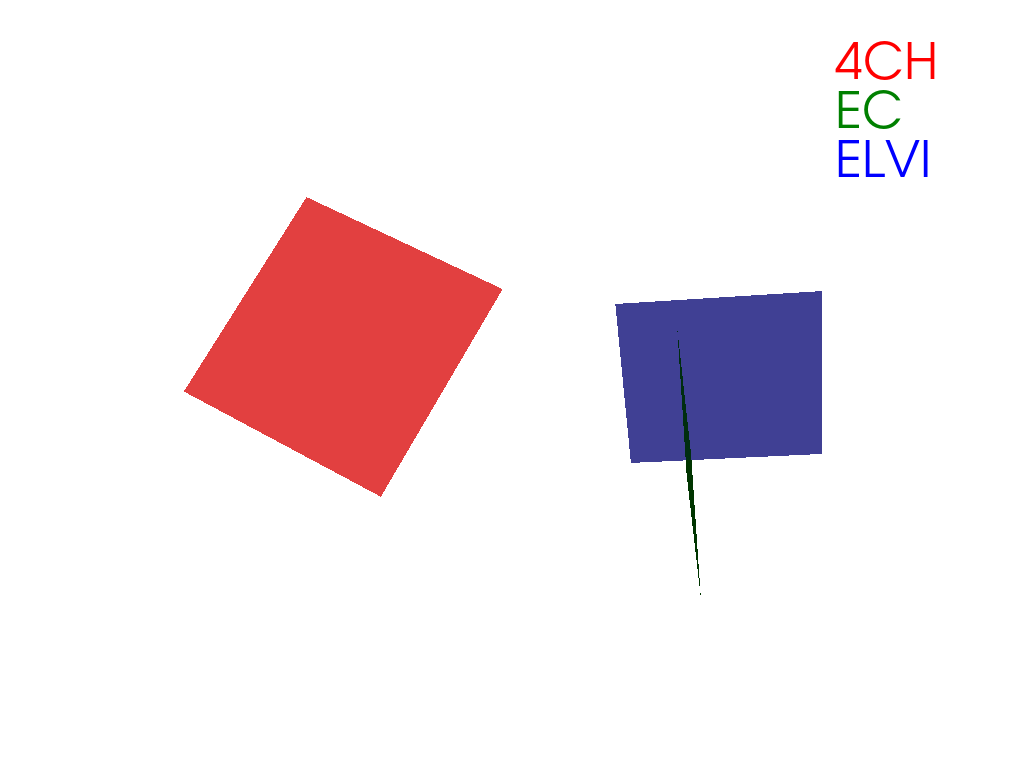

In [138]:
import nibabel as nib
import pyvista as pv
import numpy as np

# Paths to the NIfTI files
nifti_files = {
    "4CH": "0771_4CH_ED_segm.nii",
    "EC": "0771_EC_ED_segm.nii",
    "ELVI": "0771_ELVI_ED_segm.nii"
}

# Function to process a NIfTI file with multiple slices
def process_segmentation(nifti_file, name):
    # Load the NIfTI file
    nifti_data = nib.load(nifti_file)
    affine = nifti_data.affine
    voxel_size = np.sqrt(np.sum(affine[:3, :3]**2, axis=0))
    data = nifti_data.get_fdata()
    num_slices = data.shape[2]  # Number of slices along the z-axis

    # Create a container for PyVista planes
    planes = []

    for slice_idx in range(num_slices):
        # Interpolate the slice onto a 2D PyVista plane
        slice_data = data[:, :, slice_idx]
        x_size = voxel_size[0] * (data.shape[0] - 1)
        y_size = voxel_size[1] * (data.shape[1] - 1)

        # Create a PyVista plane for this slice
        grid = pv.Plane(
            center=(0, 0, 0),
            direction=(0, 0, 1),
            i_size=x_size,
            j_size=y_size,
            i_resolution=data.shape[0] - 1,
            j_resolution=data.shape[1] - 1,
        )

        # Calculate the real-world z-coordinate for this slice
        z_real = affine[2, 3] + slice_idx * affine[2, 2]

        # Convert plane points to homogeneous coordinates
        points = np.c_[grid.points, np.ones(grid.n_points)]

        # Apply affine transformation
        real_world_points = points @ affine.T

        # Update the plane points with real-world coordinates
        grid.points = real_world_points[:, :3]
        grid['intensity'] = slice_data.flatten()  # Add intensity data to the plane

        planes.append(grid)

    # Combine all planes into a multi-block dataset
    multi_block = pv.MultiBlock(planes)
    return multi_block

# Process all segmentations
real_world_segmentations = {}
for name, nifti_file in nifti_files.items():
    real_world_segmentations[name] = process_segmentation(nifti_file, name)

# Visualize the result
plotter = pv.Plotter()
colors = {"4CH": "red", "EC": "green", "ELVI": "blue"}
for name, multi_block in real_world_segmentations.items():
    for i, plane in enumerate(multi_block):
        plotter.add_mesh(plane, color=colors[name], opacity=0.5)
plotter.add_legend(labels=[(k, v) for k, v in colors.items()])
plotter.show()



In [147]:
data.shape

(384, 384, 2)

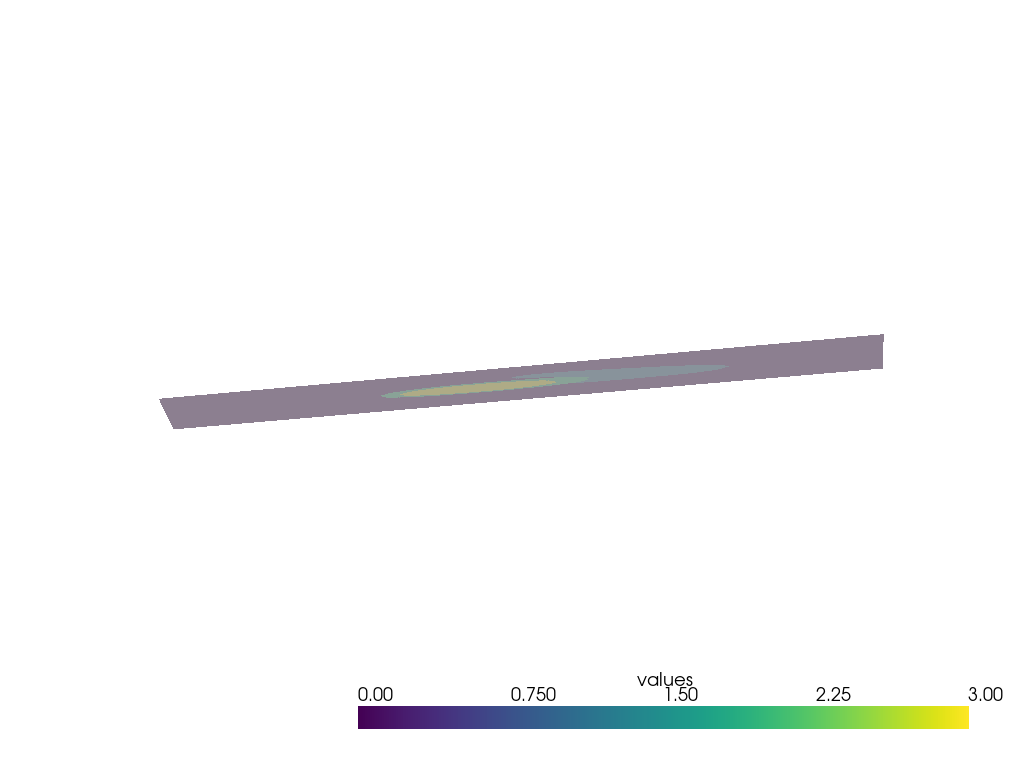

In [133]:
p = pv.Plotter()
p.add_mesh(plane, opacity=0.5)
#p.add_mesh(plane1, opacity=0.5)
#p.add_mesh(plane2, opacity=0.5)
#p.add_mesh(plane3, opacity=0.5)
p.show()

In [139]:

# Function to map a 2D segmentation slice to 3D points
def segmentation_to_3d_points(segmentation, affine, slice_index, axis):
    """
    Convert a 2D segmentation slice to 3D points using affine transformations.
    """
    indices = np.array(np.nonzero(segmentation)).T  # Get all non-zero indices (y, x)

    # Add slice index as the third axis
    if axis == 0:
        coords = np.column_stack((slice_index * np.ones(len(indices)), indices))
    elif axis == 1:
        coords = np.column_stack((indices[:, 0], slice_index * np.ones(len(indices)), indices[:, 1]))
    elif axis == 2:
        coords = np.column_stack((indices, slice_index * np.ones(len(indices))))

    # Transform to world coordinates using the affine matrix
    coords_h = np.column_stack((coords, np.ones(len(coords))))  # Homogeneous coordinates
    world_coords = coords_h @ affine.T
    world_coords = coords_h
    return world_coords[:, :3]  # Drop homogeneous component

# Load segmentation files and their affine matrices
segmentation_files = {
    "short_axis": ("0771_EC_ED_segm.nii", 0),
    "long_axis": ("0771_ELVI_ED_segm.nii", 1),
    "four_chamber": ("0771_4CH_ED_segm.nii", 2),
}

all_points = []
for name, (file_path, axis) in segmentation_files.items():
    # Load segmentation and affine
    img = nib.load(file_path)
    data = img.get_fdata()
    affine = img.affine
    points_slice = []

    # Process each slice
    for slice_index in range(data.shape[axis]):
        if axis == 0:
            segmentation = data[slice_index, :, :]
        elif axis == 1:
            segmentation = data[:, slice_index, :]
        elif axis == 2:
            segmentation = data[:, :, slice_index]

        # Get 3D points from the segmentation
        points = segmentation_to_3d_points(segmentation, affine, slice_index, axis)
        points_slice.append(points)

    all_points.append(points_slice)

# Combine all points into a single array
#all_points = np.vstack(all_points)

# Create a PyVista mesh
#point_cloud = pv.PolyData(all_points)
#point_cloud["segment"] = np.ones(len(all_points))  # Optional: Label points

# Visualize the mesh
#plotter = pv.Plotter()
#plotter.add_mesh(point_cloud, color="dodgerblue", point_size=2)
#plotter.show()

In [ ]:
s1 = pv.PolyData(np.vstack(all_points[0]))
s1.points[:500]

pyvista_ndarray([[ 75., 173.,   8.],
                 [ 75., 174.,   8.],
                 [ 75., 175.,   8.],
                 ...,
                 [ 82., 176.,   8.],
                 [ 82., 176.,   9.],
                 [ 82., 177.,   7.]])

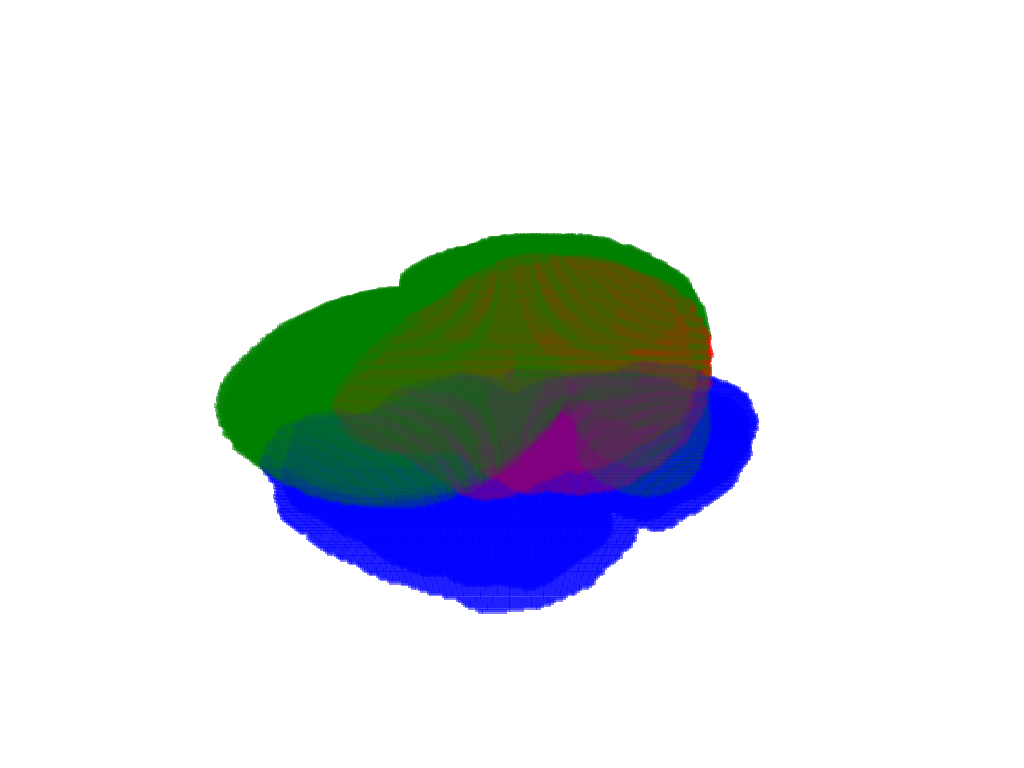

In [146]:
s1 = pv.PolyData(np.vstack(all_points[0]))
s2 = pv.PolyData(np.vstack(all_points[1]))
s3 = pv.PolyData(np.vstack(all_points[2]))
edge1 = s1.extract_feature_edges()
edge2 = s2.extract_feature_edges()
edge3 = s3.extract_feature_edges()
p = pv.Plotter()
p.add_mesh(s1, color = 'green', opacity=0.5)
p.add_mesh(s2, color = 'red', opacity=0.5)
p.add_mesh(s3, color = 'blue', opacity=0.5)
p.show()
pv.save_meshio('s1.vtk', s1)
pv.save_meshio('s2.vtk', s2)
pv.save_meshio('s3.vtk', s3)